# BAN442 — Task 1: FAA Wildlife Strikes and Weather Analysis

This notebook addresses **Task 1** by combining FAA wildlife strike data with accompanying weather data.  
The goal is to explore *when, where, and why* incidents occur, and to see if certain weather conditions are linked to strikes.  

### Structure
1. **Data Preparation**  
   - Load and clean FAA strike data (`FAA.csv`)  
   - Load and clean weather data (`weather_1.csv`, `weather_2.csv`)  
   - Extract weather features (wind speed, ceiling, visibility, temperature)  

2. **Data Integration**  
   - Combine the two weather datasets and remove duplicates  
   - Merge FAA and weather on **airport + hourly timestamp**  
   - Note: Weather data is only available for **JFK (KJFK)** and **LaGuardia (KLGA)**  

3. **Exploratory Data Analysis**  
   - #1 Species most frequently involved  
   - #2 Aircraft types most involved  
   - #3 Flight phase vs. damage level  
   - #4 Seasonal trends (incidents by month)  
   - #5–7 Weather patterns (ceiling, visibility, temperature), split by airport  

---


## 1. Setup and data preparation ##


In [52]:

# Setup

import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

# File paths

DATA_DIR = Path(".")
FAA_FILE = DATA_DIR / "FAA.csv"
W1_FILE = DATA_DIR / "weather_1.csv"
W2_FILE = DATA_DIR / "weather_2.csv"

# Weather parsing helpers

def parse_wind_speed(col: pd.Series) -> pd.Series:
    raw = col.astype(str).str.slice(5, 9)
    spd = pd.to_numeric(raw, errors="coerce")
    spd = spd.replace(9999, np.nan) / 10.0
    return spd

def parse_ceiling_height(col: pd.Series) -> pd.Series:
    raw = col.astype(str).str.slice(0, 5)
    h = pd.to_numeric(raw, errors="coerce")
    h = h.replace(99999, np.nan)
    return h

def parse_visibility(col: pd.Series) -> pd.Series:
    raw = col.astype(str).str.slice(0, 6)
    v = pd.to_numeric(raw, errors="coerce")
    v = v.replace(999999, np.nan)
    v = np.minimum(v, 160000)
    return v

def parse_air_temperature(col: pd.Series) -> pd.Series:
    raw = col.astype(str).str.slice(0, 5)
    temp = pd.to_numeric(raw.str.replace("+", "", regex=False), errors="coerce")
    temp = temp.replace(9999, np.nan) / 10.0
    return temp

# Data loading functions

def load_prepare_weather(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    ts_col = next((c for c in ["DATE", "DATE_TIME", "DATE_LOCAL", "TIME", "TIME_UTC"] if c in df.columns), None)
    if ts_col is None:
        raise KeyError("No timestamp column found.")
    df["timestamp"] = pd.to_datetime(df[ts_col], errors="coerce")
    if "WND" in df.columns:
        df["wind_speed_ms"] = parse_wind_speed(df["WND"])
    if "CIG" in df.columns:
        df["ceiling_m"] = parse_ceiling_height(df["CIG"])
    if "VIS" in df.columns:
        df["visibility_m"] = parse_visibility(df["VIS"])
    if "TMP" in df.columns:
        df["air_temp_c"] = parse_air_temperature(df["TMP"])
    for col in ["STATION", "CALL_SIGN"]:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().str.upper().replace({"99999": np.nan})
    keep = ["timestamp", "STATION", "CALL_SIGN", "wind_speed_ms", "ceiling_m", "visibility_m", "air_temp_c"]
    out = df[[c for c in keep if c in df.columns]].drop_duplicates().sort_values("timestamp").reset_index(drop=True)
    return out

def load_prepare_faa(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, low_memory=False)
    if "INCIDENT_DATE" in df.columns:
        df["INCIDENT_DATE"] = pd.to_datetime(df["INCIDENT_DATE"], errors="coerce")
    if "TIME" in df.columns:
        df["INCIDENT_TS"] = pd.to_datetime(
            df["INCIDENT_DATE"].dt.strftime("%Y-%m-%d") + " " + df["TIME"].astype(str).str.zfill(4),
            format="%Y-%m-%d %H%M", errors="coerce"
        )
    else:
        df["INCIDENT_TS"] = df["INCIDENT_DATE"]
    if "AIRPORT_ID" in df.columns:
        df["AIRPORT_ID"] = df["AIRPORT_ID"].astype(str).str.strip().str.upper()
    df = df.drop_duplicates()
    return df



In [53]:


# Sanity check: show head of each dataset
print("FAA data:")
display(faa.head())



FAA data:


,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,AIRPORT_LATITUDE,AIRPORT_LONGITUDE,RUNWAY,STATE,FAAREGION,LOCATION,OPID,OPERATOR,REG,FLT,AIRCRAFT,AMA,AMO,EMA,EMO,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,ENG_1_POS,ENG_2_POS,ENG_3_POS,ENG_4_POS,PHASE_OF_FLIGHT,HEIGHT,SPEED,DISTANCE,SKY,PRECIPITATION,AOS,COST_REPAIRS,COST_OTHER,COST_REPAIRS_INFL_ADJ,COST_OTHER_INFL_ADJ,INGESTED_OTHER,INDICATED_DAMAGE,DAMAGE_LEVEL,STR_RAD,DAM_RAD,STR_WINDSHLD,DAM_WINDSHLD,STR_NOSE,DAM_NOSE,STR_ENG1,DAM_ENG1,ING_ENG1,STR_ENG2,DAM_ENG2,ING_ENG2,STR_ENG3,DAM_ENG3,ING_ENG3,STR_ENG4,DAM_ENG4,ING_ENG4,STR_PROP,DAM_PROP,STR_WING_ROT,DAM_WING_ROT,STR_FUSE,DAM_FUSE,STR_LG,DAM_LG,STR_TAIL,DAM_TAIL,STR_LGHTS,DAM_LGHTS,STR_OTHER,DAM_OTHER,OTHER_SPECIFY,EFFECT,EFFECT_OTHER,BIRD_BAND_NUMBER,SPECIES_ID,SPECIES,OUT_OF_RANGE_SPECIES,REMARKS,REMAINS_COLLECTED,REMAINS_SENT,WARNED,NUM_SEEN,NUM_STRUCK,SIZE,ENROUTE_STATE,NR_INJURIES,NR_FATALITIES,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER,INCIDENT_TS
0,1534036,2024-02-15,2,2024,08:36,NaN,KSEA,SEATTLE-TACOMA INTL,47.44898,-122.30931,16L,WA,ANM,NaN,UNK,UNKNOWN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,R1101,American barn owl,0,From AOS - Found Barn owl on rnwy check @ 16L ...,1,0,Unknown,NaN,1,Medium,NaN,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Carcass Found,2024-05-20,0,NaT
1,1534037,2024-02-25,2,2024,09:26,NaN,KGRR,GERALD R. FORD INTL ARPT,42.88082,-85.52277,26L,MI,AGL,NaN,UNK,UNKNOWN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,R2004,Short-eared owl,0,No strike reported. Found dead on shoulder. DA...,1,0,Unknown,NaN,1,Small,NaN,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Carcass Found,2024-05-20,0,NaT
2,1534038,2024-02-25,2,2024,12:31,NaN,KLAL,LAKELAND LINDER INTERNATIONAL AIRPORT,27.98892,-82.01856,28,FL,ASO,NaN,UNK,UNKNOWN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,ZT001,Eastern meadowlark,0,Tower received a report of a dead bird on runw...,1,0,Unknown,NaN,1,Small,NaN,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Carcass Found,2024-05-20,0,NaT
3,1534039,2024-02-16,2,2024,10:32,NaN,KSLC,SALT LAKE CITY INTL,40.78839,-111.97777,16L,UT,ANM,NaN,UNK,UNKNOWN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,YH004,Horned lark,0,Bird remains found during routine runway inspe...,1,0,Unknown,NaN,1,Small,NaN,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Carcass Found,2024-05-20,0,NaT
4,1534040,2024-02-16,2,2024,09:45,NaN,KFTW,FORT WORTH MEACHAM INTL ARPT,32.81978,-97.36244,16/TWY D,TX,ASW,NaN,UNK,UNKNOWN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,K5114,American kestrel,0,Remains of strike were left on Runway centerli...,1,0,Unknown,NaN,1,Small,NaN,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Carcass Found,2024-05-20,0,NaT


In [54]:
print("\nWeather 1 data:")
display(w1.head())



Weather 1 data:


,timestamp,STATION,CALL_SIGN,wind_speed_ms,ceiling_m,visibility_m,air_temp_c
0,2024-01-01 00:00:00,72503014732,NaN,NaN,NaN,16000.0,6.1
1,2024-01-01 00:51:00,72503014732,KLGA,NaN,1524.0,16093.0,6.1
2,2024-01-01 01:51:00,72503014732,KLGA,NaN,1524.0,16093.0,6.1
3,2024-01-01 02:51:00,72503014732,KLGA,NaN,1463.0,16093.0,6.1
4,2024-01-01 03:00:00,72503014732,NaN,NaN,NaN,16000.0,6.1


In [55]:

print("\nWeather 2 data:")
display(w2.head())


Weather 2 data:


,timestamp,STATION,CALL_SIGN,wind_speed_ms,ceiling_m,visibility_m,air_temp_c
0,2024-01-01 00:00:00,74486094789,NaN,NaN,NaN,16000.0,5.6
1,2024-01-01 00:51:00,74486094789,KJFK,NaN,1524.0,16093.0,5.6
2,2024-01-01 01:51:00,74486094789,KJFK,NaN,1524.0,16093.0,5.6
3,2024-01-01 02:51:00,74486094789,KJFK,NaN,1524.0,16093.0,5.6
4,2024-01-01 03:00:00,74486094789,NaN,NaN,NaN,16000.0,5.6


## 2. Merge ##

##### Sanity and logical checks


In [56]:
# Reload FAA & Weather before merge

faa = load_prepare_faa(FAA_FILE)

w1 = load_prepare_weather(W1_FILE)
w2 = load_prepare_weather(W2_FILE)
weather = pd.concat([w1, w2], ignore_index=True).drop_duplicates().reset_index(drop=True)

# Prepare FAA timestamps

faa["INCIDENT_TS"] = pd.to_datetime(
    faa["INCIDENT_DATE"].astype(str) + " " + faa["TIME"].astype(str).str.zfill(4),
    errors="coerce"
)
faa["ts_hour"] = faa["INCIDENT_TS"].dt.floor("H")

# Prepare Weather timestamps

weather = weather[weather["CALL_SIGN"] != "99999"]  # drop missing codes
weather["ts_hour"] = pd.to_datetime(weather["timestamp"]).dt.floor("H")

# Merge FAA × Weather on ICAO + hour

merged = faa.merge(
    weather,
    left_on=["AIRPORT_ID", "ts_hour"],
    right_on=["CALL_SIGN", "ts_hour"],
    how="left",
    suffixes=("_faa", "_wx")
)


C:\Users\hpilv\AppData\Local\Temp\ipykernel_29708\481213368.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  faa["ts_hour"] = faa["INCIDENT_TS"].dt.floor("H")
C:\Users\hpilv\AppData\Local\Temp\ipykernel_29708\481213368.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather["ts_hour"] = pd.to_datetime(weather["timestamp"]).dt.floor("H")


In [57]:
# Check columns

print("FAA columns:", faa.columns.tolist())
print("Merged columns:", merged.columns.tolist())


FAA columns: ['INDEX_NR', 'INCIDENT_DATE', 'INCIDENT_MONTH', 'INCIDENT_YEAR', 'TIME', 'TIME_OF_DAY', 'AIRPORT_ID', 'AIRPORT', 'AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE', 'RUNWAY', 'STATE', 'FAAREGION', 'LOCATION', 'OPID', 'OPERATOR', 'REG', 'FLT', 'AIRCRAFT', 'AMA', 'AMO', 'EMA', 'EMO', 'AC_CLASS', 'AC_MASS', 'TYPE_ENG', 'NUM_ENGS', 'ENG_1_POS', 'ENG_2_POS', 'ENG_3_POS', 'ENG_4_POS', 'PHASE_OF_FLIGHT', 'HEIGHT', 'SPEED', 'DISTANCE', 'SKY', 'PRECIPITATION', 'AOS', 'COST_REPAIRS', 'COST_OTHER', 'COST_REPAIRS_INFL_ADJ', 'COST_OTHER_INFL_ADJ', 'INGESTED_OTHER', 'INDICATED_DAMAGE', 'DAMAGE_LEVEL', 'STR_RAD', 'DAM_RAD', 'STR_WINDSHLD', 'DAM_WINDSHLD', 'STR_NOSE', 'DAM_NOSE', 'STR_ENG1', 'DAM_ENG1', 'ING_ENG1', 'STR_ENG2', 'DAM_ENG2', 'ING_ENG2', 'STR_ENG3', 'DAM_ENG3', 'ING_ENG3', 'STR_ENG4', 'DAM_ENG4', 'ING_ENG4', 'STR_PROP', 'DAM_PROP', 'STR_WING_ROT', 'DAM_WING_ROT', 'STR_FUSE', 'DAM_FUSE', 'STR_LG', 'DAM_LG', 'STR_TAIL', 'DAM_TAIL', 'STR_LGHTS', 'DAM_LGHTS', 'STR_OTHER', 'DAM_OTHER', 'OTHE

In [58]:
# Check overlap between FAA and Weather airports

# Unique airports in FAA

faa_airports = set(faa["AIRPORT_ID"].dropna().unique())

# Unique airports in weather (from both datasets)

weather_airports = set(weather["CALL_SIGN"].dropna().unique()) - {"99999"}

# Intersection

common_airports = faa_airports.intersection(weather_airports)

print("Number of airports in FAA:", len(faa_airports))
print("Number of airports in Weather:", len(weather_airports))
print("Number of common airports:", len(common_airports))
print("Airports in both datasets:", sorted(common_airports))


Number of airports in FAA: 1075
Number of airports in Weather: 2
Number of common airports: 2
Airports in both datasets: ['KJFK', 'KLGA']


In [59]:

# Keep only rows with usable weather values

merged_weather = merged.dropna(
    subset=["wind_speed_ms", "ceiling_m", "visibility_m", "air_temp_c"],
    how="all"
)

print("FAA rows:", len(faa))
print("Weather rows:", len(weather))
print("Merged rows:", len(merged))
print("Rows with usable weather:", len(merged_weather))

merged_weather[["INCIDENT_TS","AIRPORT_ID","wind_speed_ms","ceiling_m","visibility_m","air_temp_c"]].head(20)


FAA rows: 32927
Weather rows: 42989
Merged rows: 32975
Rows with usable weather: 342


,INCIDENT_TS,AIRPORT_ID,wind_speed_ms,ceiling_m,visibility_m,air_temp_c
8,2024-02-18 11:59:00,KJFK,NaN,22000.0,16093.0,-3.9
16,2024-02-27 11:58:00,KJFK,NaN,61.0,402.0,3.9
17,2024-02-27 11:58:00,KJFK,NaN,61.0,402.0,3.9
629,2024-04-22 15:35:00,KLGA,NaN,22000.0,16093.0,11.7
1757,2024-04-28 23:30:00,KLGA,NaN,7620.0,16093.0,19.4
1885,2024-04-12 15:50:00,KLGA,NaN,122.0,4023.0,13.9
1886,2024-04-12 15:50:00,KLGA,NaN,91.0,4023.0,13.9
1887,2024-04-12 15:50:00,KLGA,NaN,91.0,4023.0,13.3
2166,2024-05-01 22:20:00,KLGA,NaN,22000.0,16093.0,15.6
2181,2024-05-06 16:50:00,KLGA,NaN,1524.0,9656.0,18.3


## 3. Data exploration ##

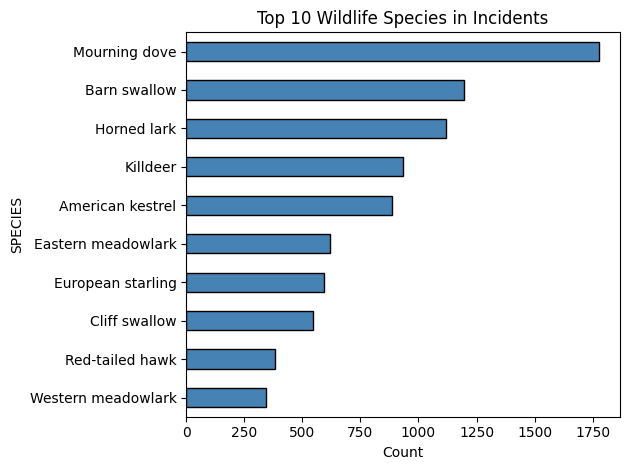

In [60]:
# 1. Incidents by species
if "SPECIES" in faa.columns:
    # Filter out all species containing 'Unknown' (case-insensitive)
    species_counts = faa[~faa["SPECIES"].str.contains("Unknown", case=False, na=False)]["SPECIES"].value_counts()
    
    # Select top 10
    top_species = species_counts.head(10)
    
    # Plot
    top_species.sort_values().plot(kind="barh", color="steelblue", edgecolor="black")
    plt.title("Top 10 Wildlife Species in Incidents")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()



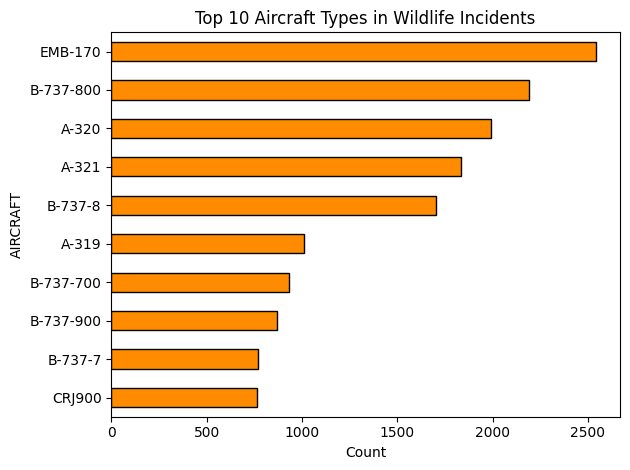

In [61]:
# 2. Incidents by aircraft type
if "AIRCRAFT" in faa.columns:
    # Filter out UNKNOWN aircraft
    aircraft_counts = faa[faa["AIRCRAFT"] != "UNKNOWN"]["AIRCRAFT"].value_counts()
    
    # Select top 10
    top_aircraft = aircraft_counts.head(10)
    
    # Plot
    top_aircraft.sort_values().plot(kind="barh", color="darkorange", edgecolor="black")
    plt.title("Top 10 Aircraft Types in Wildlife Incidents")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()



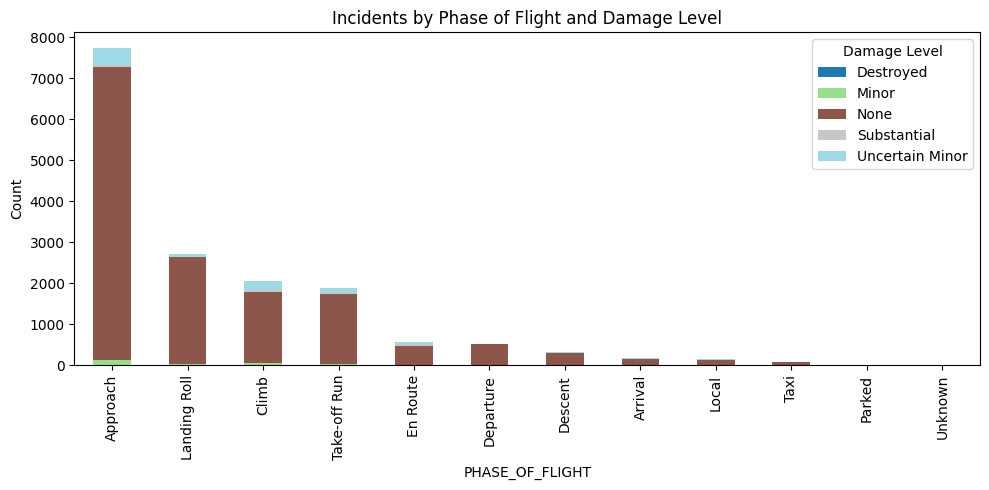

In [62]:

# 3. Flight phase × damage level
damage_map = {
    "N": "None",
    "M": "Minor",
    "M?": "Uncertain Minor",
    "S": "Substantial",
    "D": "Destroyed"
}

if {"PHASE_OF_FLIGHT", "DAMAGE_LEVEL"}.issubset(faa.columns):
    # Map damage codes to readable labels
    faa["DAMAGE_LABEL"] = faa["DAMAGE_LEVEL"].map(damage_map).fillna(faa["DAMAGE_LEVEL"])
    
    # Crosstab with readable labels
    phase_damage = pd.crosstab(faa["PHASE_OF_FLIGHT"], faa["DAMAGE_LABEL"])
    phase_damage = phase_damage.loc[phase_damage.sum(axis=1).sort_values(ascending=False).index]
    
    # Plot
    phase_damage.plot(kind="bar", stacked=True, figsize=(10,5), colormap="tab20")
    plt.title("Incidents by Phase of Flight and Damage Level")
    plt.ylabel("Count")
    plt.legend(title="Damage Level")
    plt.tight_layout()
    plt.show()



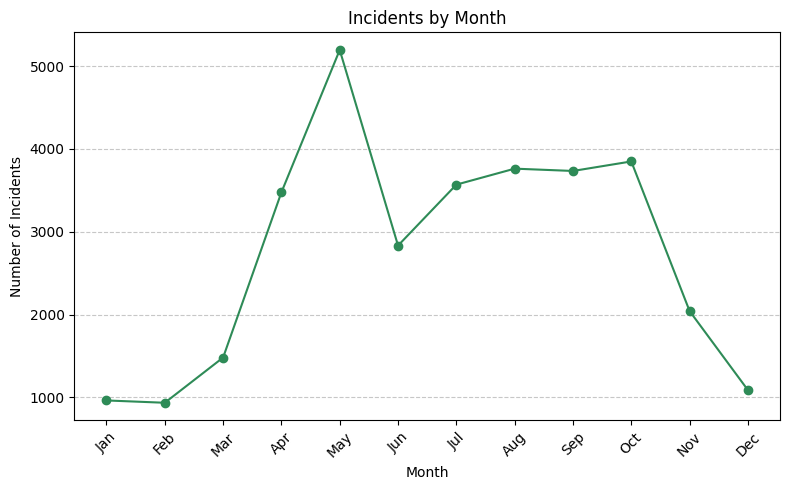

In [63]:

# 4. Seasonal/Monthly trends
import calendar
if "INCIDENT_DATE" in faa.columns:
    faa["month"] = faa["INCIDENT_DATE"].dt.month
    monthly_counts = faa["month"].value_counts().sort_index()

    plt.figure(figsize=(8,5))
    plt.plot(monthly_counts.index, monthly_counts.values, marker="o", linestyle="-", color="seagreen")
    plt.title("Incidents by Month")
    plt.xlabel("Month")
    plt.ylabel("Number of Incidents")
    plt.xticks(range(1,13), calendar.month_abbr[1:13], rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


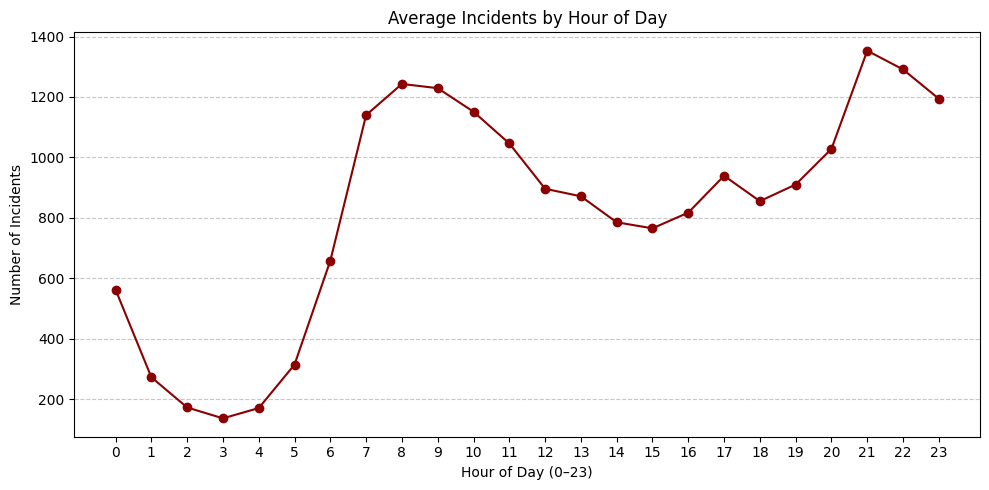

In [73]:
# 4. Incidents by Time of Day (hourly average)
if "INCIDENT_DATE" in faa.columns and "INCIDENT_TS" in faa.columns:
    # Extract hour of incident
    faa["hour"] = faa["INCIDENT_TS"].dt.hour
    
    # Count incidents per hour
    hourly_counts = faa["hour"].value_counts().sort_index()
    
    plt.figure(figsize=(10,5))
    plt.plot(hourly_counts.index, hourly_counts.values, marker="o", linestyle="-", color="darkred")
    plt.title("Average Incidents by Hour of Day")
    plt.xlabel("Hour of Day (0–23)")
    plt.ylabel("Number of Incidents")
    plt.xticks(range(0,24))
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


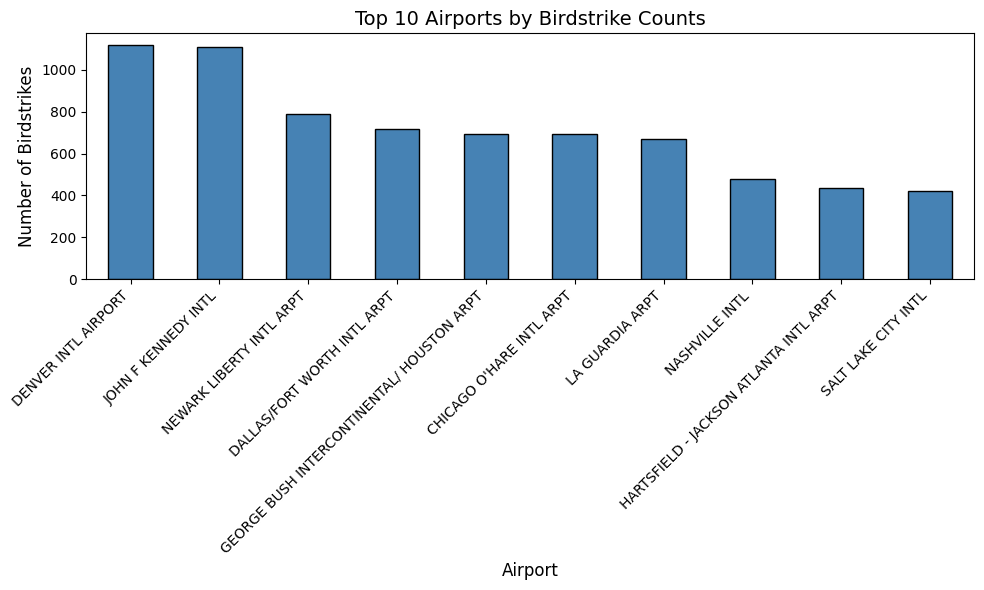

In [64]:

# 5. Top 10 Airports by Birdstrike Counts

# Filter out UNKNOWN airports and count birdstrikes
airport_counts = faa[faa['AIRPORT'] != "UNKNOWN"]['AIRPORT'].value_counts()

# Select top 10
top10_airports = airport_counts.head(10)

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top10_airports.plot(kind="bar", color="steelblue", edgecolor="black")
plt.title("Top 10 Airports by Birdstrike Counts", fontsize=14)
plt.xlabel("Airport", fontsize=12)
plt.ylabel("Number of Birdstrikes", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



C:\Users\hpilv\AppData\Local\Temp\ipykernel_29708\733267247.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_weather["ceiling_category"] = pd.cut(merged_weather["ceiling_m"], bins=bins, labels=labels, include_lowest=True)
C:\Users\hpilv\AppData\Local\Temp\ipykernel_29708\733267247.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_weather.groupby(["AIRPORT_ID","ceiling_category"]).size().unstack(0).plot(


<Figure size 800x500 with 0 Axes>

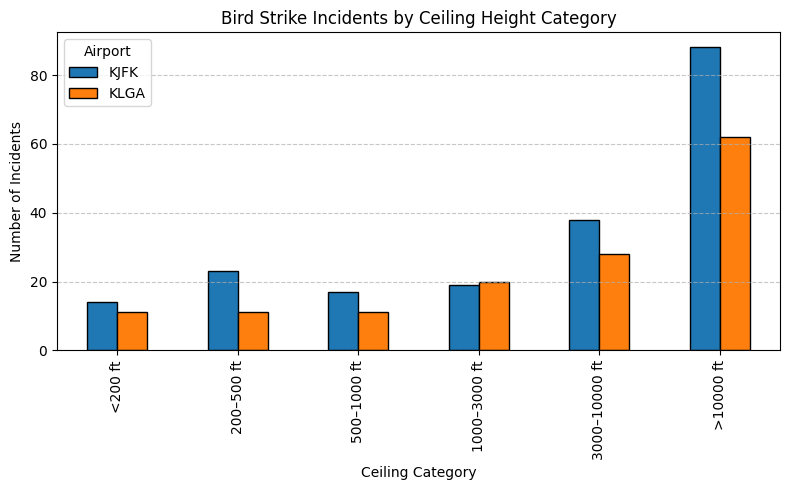

In [65]:

# 6. Weather – Ceiling categories
bins = [0, 200, 500, 1000, 3000, 10000, 30000]
labels = ["<200 ft", "200–500 ft", "500–1000 ft", "1000–3000 ft", "3000–10000 ft", ">10000 ft"]
merged_weather["ceiling_category"] = pd.cut(merged_weather["ceiling_m"], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(8,5))
merged_weather.groupby(["AIRPORT_ID","ceiling_category"]).size().unstack(0).plot(
    kind="bar", edgecolor="black", figsize=(8,5)
)
plt.title("Bird Strike Incidents by Ceiling Height Category")
plt.xlabel("Ceiling Category")
plt.ylabel("Number of Incidents")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Airport")
plt.tight_layout()
plt.show()


C:\Users\hpilv\AppData\Local\Temp\ipykernel_29708\1884650115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_weather["visibility_category"] = pd.cut(merged_weather["visibility_m"], bins=bins, labels=labels, include_lowest=True)
C:\Users\hpilv\AppData\Local\Temp\ipykernel_29708\1884650115.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_weather.groupby(["AIRPORT_ID","visibility_category"]).size().unstack(0).plot(


<Figure size 800x500 with 0 Axes>

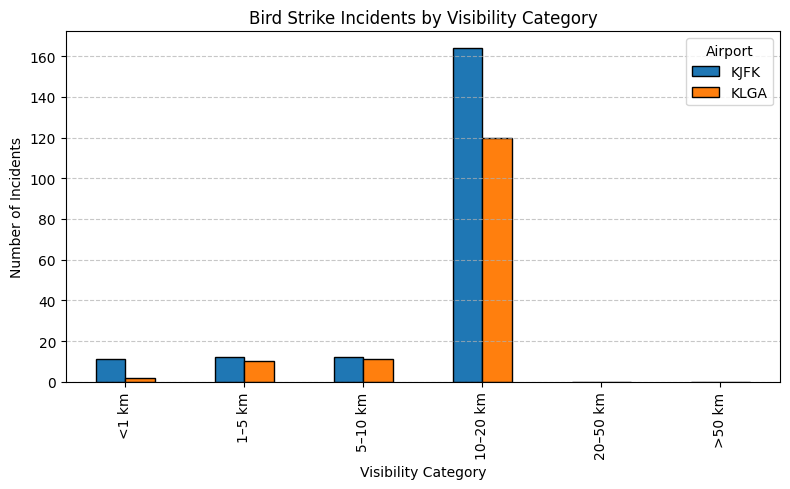

In [66]:

# 7. Weather – Visibility categories
bins = [0, 1000, 5000, 10000, 20000, 50000, 160000]
labels = ["<1 km", "1–5 km", "5–10 km", "10–20 km", "20–50 km", ">50 km"]
merged_weather["visibility_category"] = pd.cut(merged_weather["visibility_m"], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(8,5))
merged_weather.groupby(["AIRPORT_ID","visibility_category"]).size().unstack(0).plot(
    kind="bar", edgecolor="black", figsize=(8,5)
)
plt.title("Bird Strike Incidents by Visibility Category")
plt.xlabel("Visibility Category")
plt.ylabel("Number of Incidents")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Airport")
plt.tight_layout()
plt.show()


C:\Users\hpilv\AppData\Local\Temp\ipykernel_29708\1552569472.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_weather["temp_category"] = pd.cut(merged_weather["air_temp_c"], bins=bins, labels=labels, include_lowest=True)
C:\Users\hpilv\AppData\Local\Temp\ipykernel_29708\1552569472.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_weather.groupby(["AIRPORT_ID","temp_category"]).size().unstack(0).plot(


<Figure size 800x500 with 0 Axes>

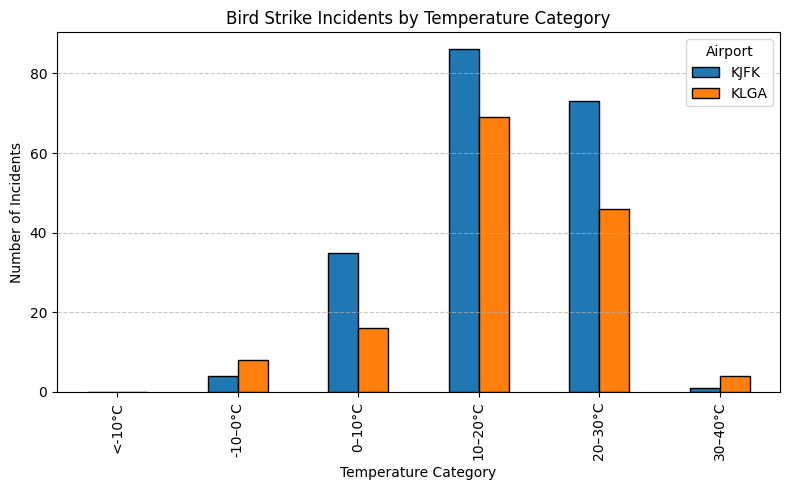

In [67]:

# 8. Weather – Temperature categories
bins = [-20, -10, 0, 10, 20, 30, 40]
labels = ["<-10°C", "-10–0°C", "0–10°C", "10–20°C", "20–30°C", "30–40°C"]
merged_weather["temp_category"] = pd.cut(merged_weather["air_temp_c"], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(8,5))
merged_weather.groupby(["AIRPORT_ID","temp_category"]).size().unstack(0).plot(
    kind="bar", edgecolor="black", figsize=(8,5)
)
plt.title("Bird Strike Incidents by Temperature Category")
plt.xlabel("Temperature Category")
plt.ylabel("Number of Incidents")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Airport")
plt.tight_layout()
plt.show()
